In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
TcContT0 = pd.read_csv("/Users/nick/../../Volumes/MBT/Non_RP/READS/TcContT0.counts.csv", sep=";", header = [0])
TcContT3 = pd.read_csv("/Users/nick/../../Volumes/MBT/Non_RP/READS/TcContT3.counts.csv", sep=";", header = [0])
TcInfT0 = pd.read_csv("/Users/nick/../../Volumes/MBT/Non_RP/READS/TcInfT0.counts.csv", sep=";", header = [0])
TcInfT3 = pd.read_csv("/Users/nick/../../Volumes/MBT/Non_RP/READS/TcInfT3.counts.csv", sep=";", header = [0])

In [3]:
def clean_bacterial_taxons(df):
    #select only bacteria
    bact_only = df[df["Domain"] == "Bacteria"]
    
    #drop empty columns
    bact_only = bact_only.iloc[:,:7]
    
    #fill empty values with unknowns
    bact_only = bact_only.fillna("Unknown")
    
    return bact_only

def filter_low_counts(df,n):
    #group by bacterial class
    classes = df.groupby("Class")
    
    #sum the number of reads for each class
    sums = classes["No. Reads"].sum()
    sums = sums.reset_index()
    
    #combine anything with less than n reads into an other category
    other = sums[sums["No. Reads"] < n]
    major_taxa = sums[sums["No. Reads"] >= n]
    
    #append other total to final dataframe 
    other_total = ["Other", other["No. Reads"].sum()]
    other_total = pd.DataFrame(other_total)
    other_total = other_total.T
    other_total.columns = ["Class", "No. Reads"]
    final = pd.concat([major_taxa, other_total], axis = 0, ignore_index= True)
    return final

def get_proportions(df):
    df_scaled = df.copy()
    #total all reads
    sum_reads = df_scaled["No. Reads"].sum()
    #figure out proportions
    df_scaled["proportion"] = df_scaled["No. Reads"]/sum_reads 
    #drop reads column
    df_scaled = df_scaled.drop("No. Reads",axis=1)
    
    return df_scaled

In [4]:
TcContT0_bact = clean_bacterial_taxons(TcContT0)
TcContT3_bact = clean_bacterial_taxons(TcContT3)
TcInfT0_bact = clean_bacterial_taxons(TcInfT0)
TcInfT3_bact = clean_bacterial_taxons(TcInfT3)

In [5]:
TcContT0_filter = filter_low_counts(TcContT0_bact,500)
TcContT3_filter = filter_low_counts(TcContT3_bact,500)
TcInfT0_filter = filter_low_counts(TcInfT0_bact,500)
TcInfT3_filter = filter_low_counts(TcInfT3_bact,500)

In [6]:
TcContT0_scaled = get_proportions(TcContT0_filter)
TcContT3_scaled = get_proportions(TcContT3_filter)
TcInfT0_scaled = get_proportions(TcInfT0_filter)
TcInfT3_scaled = get_proportions(TcInfT3_filter)

In [7]:
merge1 = pd.merge(TcContT0_scaled,TcContT3_scaled, how='outer', on='Class')
merge2 = pd.merge(merge1,TcInfT0_scaled, how='outer', on='Class')
merge3 = pd.merge(merge2,TcInfT3_scaled, how='outer', on='Class')

In [8]:
merge3.columns = ["Class", "TcContT0", "TcContT3", "TcInfT0", "TcInfT3"]

In [9]:
merge3 =merge3.fillna(0).replace("Chlamydiia", "Chlamydiales")
final_table = merge3.set_index("Class").sort_values(by='TcContT0', ascending = False)

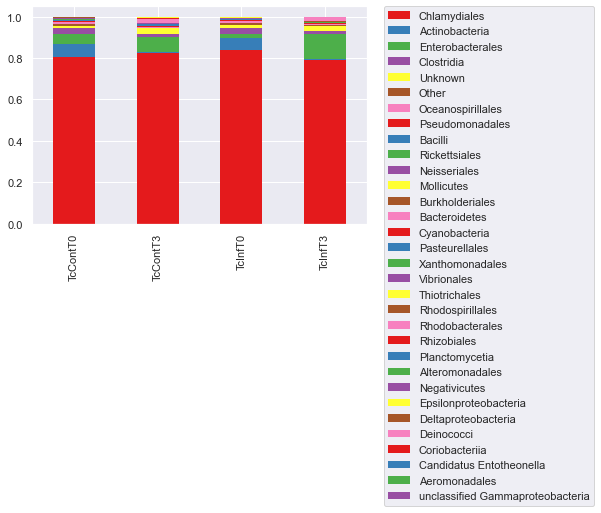

In [10]:
sns.set()
final_table.T.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("Set1", 40)),edgecolor="none")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('taxa_proportions.pdf')


In [11]:
TcContT0["Domain"].value_counts()

Bacteria     3864
Eukaryota    1364
Archaea        98
Name: Domain, dtype: int64

In [12]:
def get_group(df,group):
    #group by bacterial class
    groups = df.groupby(group)
    
    #sum the number of reads for each group
    sums = groups["No. Reads"].sum()
    sums = sums.reset_index()
    

    return sums

In [13]:
TcContT0_all = get_group(TcContT0,"Domain")
TcContT3_all = get_group(TcContT3,"Domain")
TcInfT0_all = get_group(TcInfT0,"Domain")
TcInfT3_all = get_group(TcInfT3,"Domain")


In [14]:
merge_all_1 = pd.merge(TcContT0_all,TcContT3_all, how='outer', on='Domain')
merge_all_2 = pd.merge(merge_all_1,TcInfT0_all, how='outer', on='Domain')
merge_all_3 = pd.merge(merge_all_2,TcInfT3_all, how='outer', on='Domain')

In [15]:
merge_all_3.columns = ["Domain", "TcContT0", "TcContT3", "TcInfT0", "TcInfT3"]

In [16]:
#get the totals for different viruses
viral_sub = merge_all_3[3:11].T
viral_sub["Viruses"] = viral_sub.sum(axis=1)
viral_sub = viral_sub.drop("Domain")
viral_total = viral_sub["Viruses"]

final_merged = merge_all_3.T

#reset header
header = final_merged.iloc[0]
final_merged = final_merged[1:] #take the data less the header row
final_merged.columns = header

#drop individual virus columns and add in total
final_merged = final_merged.drop(["Retro-transcribing viruses","dsDNA viruses, no RNA stage","dsRNA viruses","environmental samples","ssDNA viruses","ssRNA viruses", "unclassified bacterial viruses","unclassified viruses", "unclassified virophages"], axis=1)
final_merged["Viruses"] = viral_sub["Viruses"]

In [17]:
#get proportions for domains
def proportions(df):
    df["total"] = df["Archaea"] + df["Bacteria"] + df["Eukaryota"] + df["Viruses"]
    df["Archaea_prop"] = df["Archaea"] / df["total"]
    df["Bacteria_prop"] = df["Bacteria"] / df["total"]
    df["Eukaryota_prop"] = df["Eukaryota"] / df["total"]
    df["Virus_prop"] = df["Viruses"] / df["total"]
    df = df.drop(["Archaea", "Bacteria", "Eukaryota", "Viruses","total"],axis=1)
    df.columns = ["Archaea", "Bacteria", "Eukaryota", "Viruses"]
    return df

prop_merged = proportions(final_merged)


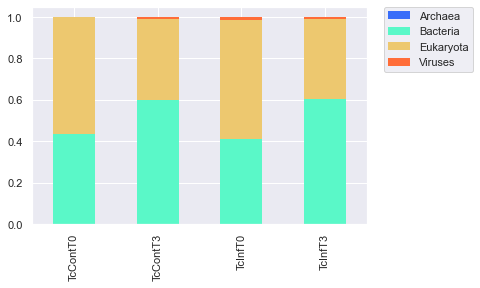

In [18]:
prop_merged.plot(kind='bar', stacked=True, colormap=ListedColormap(sns.color_palette("rainbow")),edgecolor="none")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('domain_graph.pdf')